<a href="https://colab.research.google.com/github/gc2321/3546-Deep-Learning/blob/main/assign_2/assign_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Flowers using Transfer Learning in Keras

Assignment 2 - Convolutional Neural Nets and Transfer Learning

By Gordon Chan (qq525548)


In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed(42)


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
data_dir = "/content/gdrive/MyDrive/3546/assign_2/flower_photos"

In [5]:
os.listdir(data_dir)

['tulips', 'roses', 'sunflowers', 'dandelion', 'daisy']

In [6]:
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

## Loading data

In [7]:
from sklearn.model_selection import train_test_split

# Get the list of classes (folders)
classes = ['tulips', 'roses', 'sunflowers', 'dandelion', 'daisy']

# Initialize the lists to store the images and labels
images = []
labels = []

# Desired dimensions
target_height = 224
target_width = 224

# Loop through each class folder
for class_ in classes:
    # Get the list of images in the current class folder
    image_paths = tf.io.gfile.glob(f'{data_dir}/{class_}/*.jpg')

    # Loop through each image
    for image_path in image_paths:
        # Read the image
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)

        # Add the image and label to the lists
        images.append(image)
        labels.append(class_)

# Split the data into training and testing sets (80% for training and 20% for testing)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Print the shapes of the training and testing sets
print(f'Training images shape: {len(train_images)}')
print(f'Testing images shape: {len(test_images)}')

Training images shape: 2936
Testing images shape: 734


In [8]:
# split off 15% of training set as validation set
validation_images, remaining_images, validation_labels, remaining_labels = train_test_split(
    train_images, train_labels, test_size=0.85, random_state=42, stratify=train_labels
)

# Update the training data to be the remaining images and labels
train_images = remaining_images
train_labels = remaining_labels

In [9]:
print(f'Training images shape: {len(train_images)}')
print(f'Validation images shape: {len(validation_images)}')
print(f'Testing images shape: {len(test_images)}')

Training images shape: 2496
Validation images shape: 440
Testing images shape: 734


In [10]:
def show_images(images, num, labels):
    plt.figure(figsize=(10, 10))
    for i in range(num):
      plt.subplot(3, 3, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.binary)
      plt.xlabel(labels[i])
    plt.show()

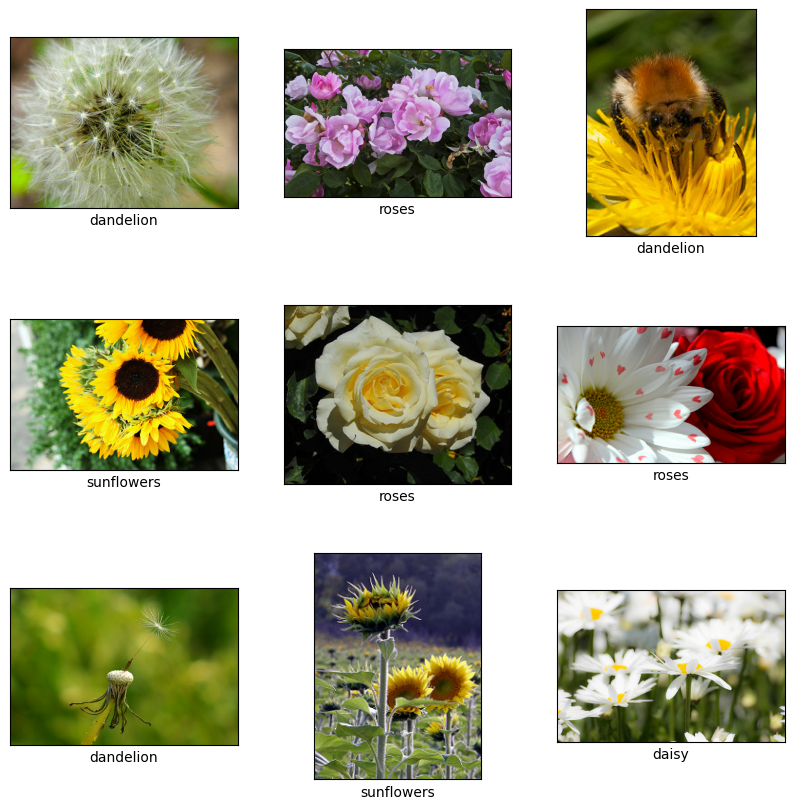

In [11]:
show_images(train_images, 9, train_labels)

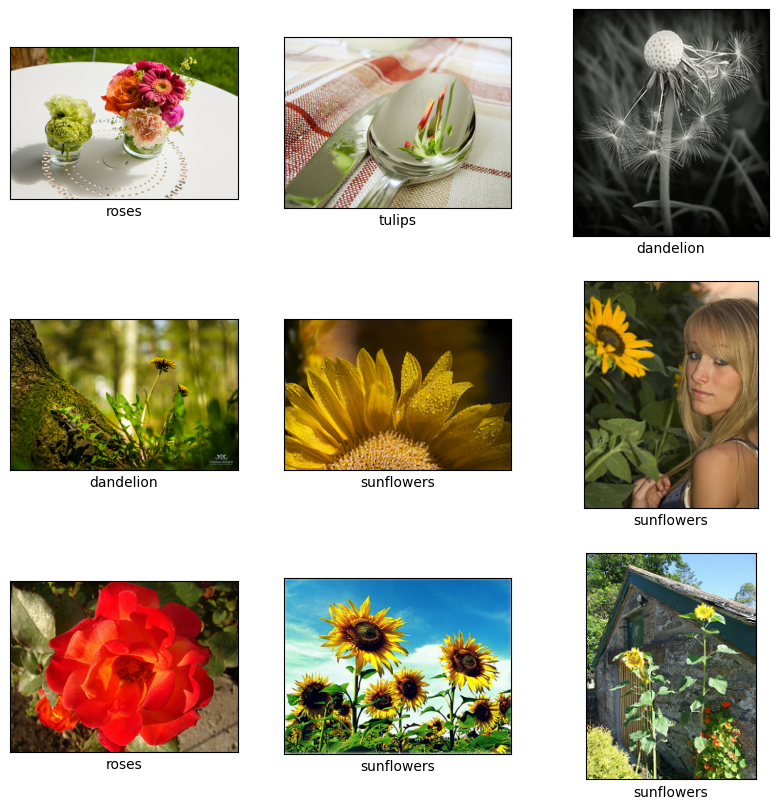

In [12]:
show_images(validation_images, 9, validation_labels)

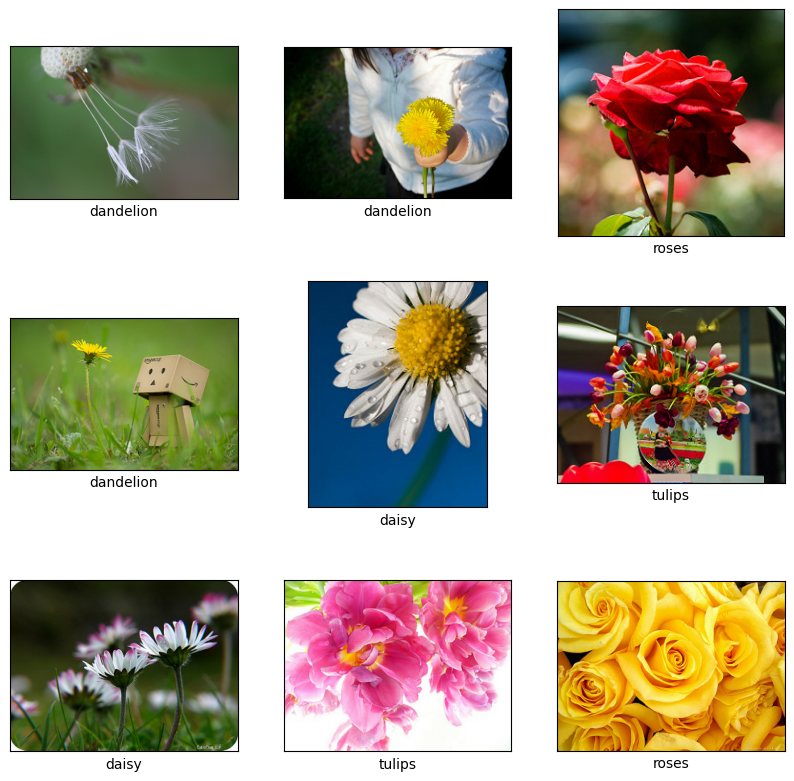

In [13]:
show_images(test_images, 9, test_labels)

### Preprocessing Images

In [14]:
def string_to_tensor(str):
   index = class_names.index(str)
   return tf.convert_to_tensor(index, dtype=tf.int64)

In [23]:
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

In [35]:
def transform_images(images, labels):
  labels = [string_to_tensor(s) for s in labels]
  image_set = [preprocess(x) for x in images]
  dataset = tf.data.Dataset.from_tensor_slices((image_set, labels))
  return dataset

In [43]:
def show_dataset_images(dataset):
  plt.figure(figsize=(12, 10))
  index = 0
  for image, label in dataset.take(9):
      index += 1
      plt.subplot(3, 3, index)
      image = np.clip(image, 0, 255)
      plt.imshow(image)
      plt.title(f"Label: {class_names[label]}")
      plt.axis("off")

  plt.show()

In [37]:
train_dataset = transform_images(train_images, train_labels)

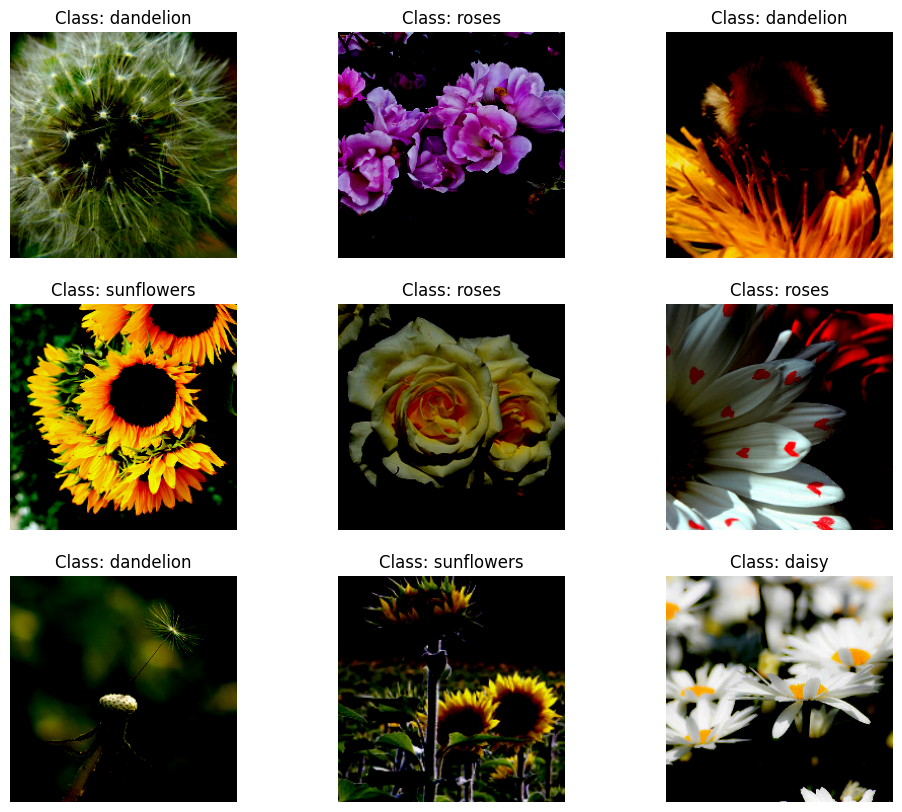

In [44]:
show_dataset_images(train_dataset)

In [40]:
validation_dataset = transform_images(validation_images, validation_labels)

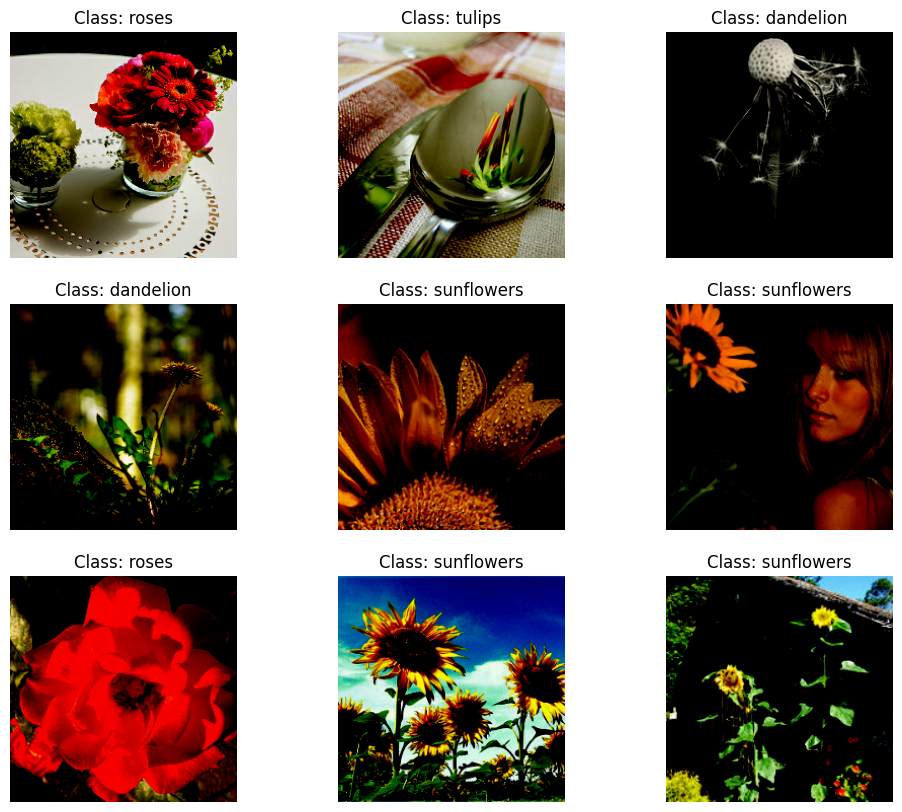

In [45]:
show_dataset_images(validation_dataset)

In [46]:
test_dataset = transform_images(test_images, test_labels)

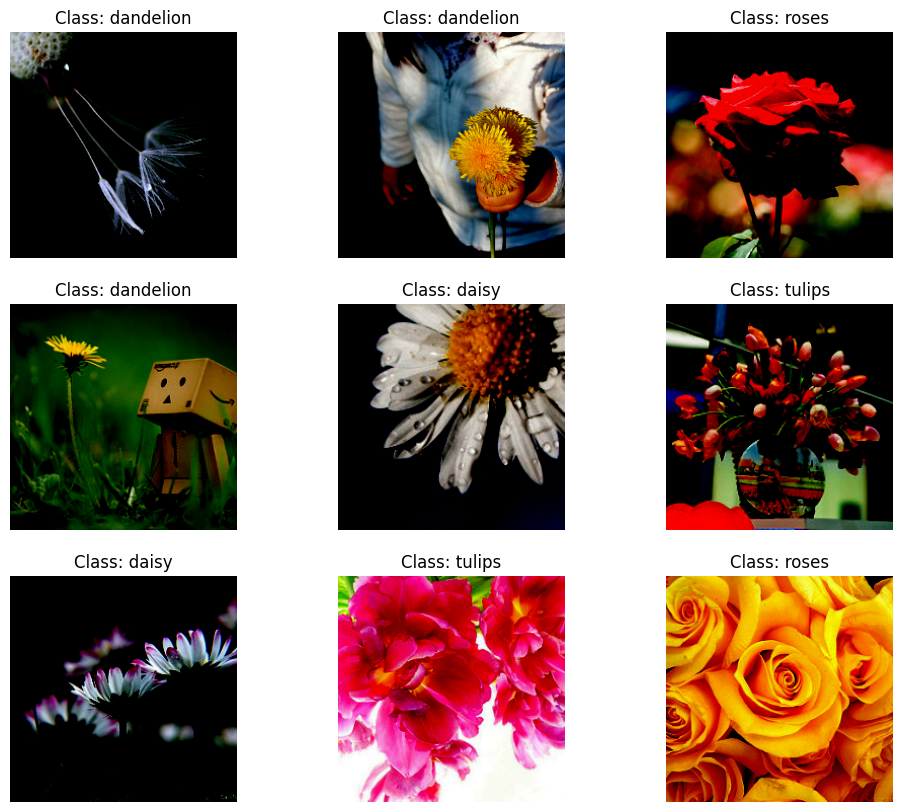

In [47]:
show_dataset_images(test_dataset)

### Batching

In [53]:
batch_size = 32

In [54]:
# shuffling the data set to ensure training model does not learn any unintended patterns due to the order of the data
# Prefetching improves the efficiency of data loading by overlapping the data preprocessing and model training.
train_set = train_dataset.shuffle(1000, seed=42).batch(batch_size).prefetch(1)

In [57]:
valid_set = validation_dataset.batch(batch_size)
test_set = test_dataset.batch(batch_size)